<a href="https://colab.research.google.com/github/leeyoungchang/Youngchang/blob/master/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image

import seaborn as sns
from pylab import rcParams
# plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler


## 반도체 생산 공정 데이터를 이용하여 이상치 탐지 모델 구축을 위한 데이터셋 준비하기

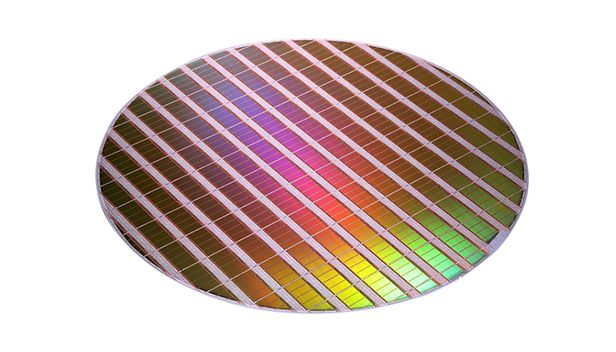

In [ ]:
Image('/content/drive/MyDrive/ml/Lectures/Lectures/images/samsung.jpeg')

- SECOM dataset은 wafer 공정의 생산 라인에서 나온 1567 개의 examples로 구성됨
- 각 example은 590개 센서에 대한 데이터를 가짐
- 1567 개 중 104 개는 fail되었고, 이것은 1 이라고 라벨링 됨. 반면에, 나머지 성공한 case는 -1로 라벨링 됨.
- ISSUE: Imblanced data

Abstract: Data from a semi-conductor manufacturing process

- Data Set Characteristics: Multivariate
- Number of Instances: 1567
- Area: Computer
- Attribute Characteristics: Real
- Number of Attributes: 591
- Associated Tasks: Classification, Causal-Discovery
- Missing Values? Yes

## Data Load

In [3]:
df_path = '/content/drive/MyDrive/딥러닝/uci-secom.csv'

In [6]:
df = pd.read_csv(df_path)
df.head(3)

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,...,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,...,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,...,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.1,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1


In [7]:
## check columns
df.columns

Index(['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '581', '582', '583', '584', '585', '586', '587', '588', '589',
       'Pass/Fail'],
      dtype='object', length=592)

In [8]:
# To avoid an error
df = df.rename({"Pass/Fail":'Pass_Fail'},axis=1)

In [9]:
def hap(x, y):
    return x + y

print(hap(10,20))
print((lambda x,y: x + y)(10, 20))

30
30


## Data Preprocessing

In [10]:
df.dtypes

Time          object
0            float64
1            float64
2            float64
3            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass_Fail      int64
Length: 592, dtype: object

In [ ]:
df.isnull()

In [13]:
df.isnull().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass_Fail     0
Length: 592, dtype: int64

In [14]:
Types = df.dtypes
Counts = df.apply(lambda x:x.count())
Min = df.min()
Max = df.max()
Nulls = df.apply(lambda x: x.isnull().sum())
Uniques = df.apply(lambda x: x.unique().shape[0])

cols = ['Types', 'Counts', 'Min', 'Max','Uniques','Nulls']

data_exploration_table = pd.concat([Types,Counts,Min,Max,Uniques,Nulls],axis=1)
data_exploration_table.columns = cols

data_exploration_table

,Types,Counts,Min,Max,Uniques,Nulls
Time,object,1567,2008-01-08 02:02:00,2008-12-10 18:47:00,1534,0
0,float64,1561,2743.24,3356.35,1521,6
1,float64,1560,2158.75,2846.44,1505,7
2,float64,1553,2060.66,2315.27,508,14
3,float64,1553,0,3715.04,519,14
...,...,...,...,...,...,...
586,float64,1566,-0.0169,0.1028,323,1
587,float64,1566,0.0032,0.0799,261,1
588,float64,1566,0.001,0.0286,121,1
589,float64,1566,0,737.305,612,1


### 결측치 확인

In [ ]:
# 0%, 50%
def null_values(df, threshold):
    

    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage'})
    return nv[nv.Percentage > threshold].sort_values('Missing_Records', ascending=False)

null_50 = null_values(df,50)
null_50

,Missing_Records,Percentage
292,1429,91.193363
293,1429,91.193363
157,1429,91.193363
158,1429,91.193363
85,1341,85.577537
492,1341,85.577537
220,1341,85.577537
358,1341,85.577537
517,1018,64.964901
516,1018,64.964901


In [ ]:
null_50.shape

(28, 2)

In [ ]:
null_50.index

Index(['292', '293', '157', '158', '85', '492', '220', '358', '517', '516',
       '384', '383', '382', '518', '246', '245', '244', '111', '110', '109',
       '580', '579', '578', '581', '72', '346', '73', '345'],
      dtype='object')

### 결측치 부분 제거

In [ ]:
## 결측치가 50% 이상으로 이루어진 columns은 제거
df = df.drop(axis=1, columns=null_50.index)
df.shape

(1567, 564)

### 결측치 채우기

In [ ]:
## 남아있는 0 - 49% 내의 결측치를 갖고 있는 columns 결측치 처리
df.fillna(method='ffill', inplace=True)
df

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,582,583,584,585,586,587,588,589,Pass_Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,...,395.570,75.752,0.4234,12.93,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,...,408.798,74.640,0.7193,16.00,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,...,411.136,74.654,0.1832,16.16,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,62.9333,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,65.1951,86.6867,...,372.822,72.442,1.8804,131.68,39.33,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,1.1613,0.7288,0.2710,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,62.8333,3.1556,0.2696,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,86.1468,...,399.914,79.156,1.0388,19.63,1.98,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,-0.0057,0.9579,203.9867,0.0,11.7692,419.3404,10.2397,0.9693,193.7470,12.5373,1.4072,-5418.75,2608.00,-6228.25,356.00,1.2817,1.9540,7.0793,71.1444,2.2222,0.1753,3.4680,83.8405,8.7164,50.2482,64.3573,49.7518,66.2013,86.3672,...,401.774,77.166,1.1040,16.90,0.80,0.4754,8.5138,0.3141,85.1806,4.2063,1.0367,1.0972,0.3553

In [ ]:
##recheck
null_values(df,1) # 결측치가 1% 이상인 columns 출력

,Missing_Records,Percentage


### 유일값 확인

In [ ]:
#sample
df["5"].nunique()

1

In [ ]:
def check_unique_col(df):

    lists=[]
    for c in df.columns:
        if df[c].nunique() == 1:
            lists.append(c)
    return lists

print(check_unique_col(df))
print('Length of unique columns: ',len(check_unique_col(df)))

['5', '13', '42', '49', '52', '69', '97', '141', '149', '178', '179', '186', '189', '190', '191', '192', '193', '194', '226', '229', '230', '231', '232', '233', '234', '235', '236', '237', '240', '241', '242', '243', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '276', '284', '313', '314', '315', '322', '325', '326', '327', '328', '329', '330', '364', '369', '370', '371', '372', '373', '374', '375', '378', '379', '380', '381', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '414', '422', '449', '450', '451', '458', '461', '462', '463', '464', '465', '466', '481', '498', '501', '502', '503', '504', '505', '506', '507', '508', '509', '512', '513', '514', '515', '528', '529', '530', '531', '532', '533', '534', '535', '536', '537', '538']
Length of unique columns:  116


### 유일값 제거

In [ ]:
df = df.drop(axis=1,columns=check_unique_col(df))
df.shape

(1567, 448)

### Time 칼럼 삭제

In [ ]:
df.drop(columns="Time", axis=1, inplace=True)
df.shape

(1567, 447)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 447 entries, 0 to Pass_Fail
dtypes: float64(446), int64(1)
memory usage: 5.3 MB


## EDA (Explonary Data Analysis)

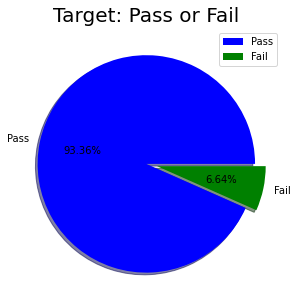

-1    1463
 1     104
Name: Pass_Fail, dtype: int64

In [ ]:
plt.rcParams['figure.figsize'] = (5,5) # 차트 그림(figure)의 기본 설정을 지정
labels = ['Pass', 'Fail']
size = df['Pass_Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True) # pie 그래프 사용하겠다
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
df["Pass_Fail"].value_counts()

- 이 데이터셋은 불균형 imbalanced 하다.

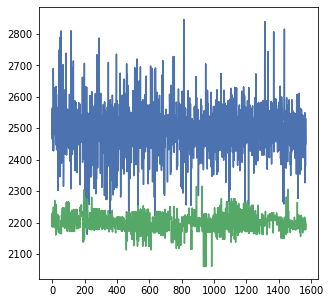

In [ ]:
plt.plot(df["1"])
plt.plot(df["2"])
plt.show()

## Building dataset

In [ ]:
X = df.drop('Pass_Fail',axis=1)
y = df['Pass_Fail']

print(X.shape)
print(y.shape)

(1567, 446)
(1567,)


In [ ]:
# the function train_test_split creates random data samples (default: 75-25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=827)

# gettiing the shapes
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of X_train:  (1175, 446)
shape of X_test:  (392, 446)
shape of y_train:  (1175,)
shape of y_test:  (392,)


### scaling

In [ ]:
X_train.head(3)

,0,1,2,3,4,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,...,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,582,583,584,585,586,587,588,589
53,3058.98,2484.31,2172.9778,1222.6067,1.3658,101.8400,0.1220,1.5321,-0.0008,0.0047,0.9527,200.0029,13.4387,422.3048,10.6441,0.9768,189.3587,12.4278,1.4160,-5545.00,2624.0,-3817.0,-3835.2500,1.3265,1.9772,7.3942,64.0778,2.5000,0.2111,3.4639,85.6591,8.8249,50.3878,64.1536,49.6122,65.8859,86.8889,118.3554,79.48,2.419,...,0.5413,403.658,71.830,0.2893,19.63,0.92,0.1171,8.6258,0.3592,53.4412,4.8630,1.2808,0.9208,0.1456,0.0334,15.8112,261.714,0.6509,0.97,0.0605,0.4562,0.0254,0.3706,9.2984,532.5454,2.1461,8.74,0.3500,3.1643,0.0927,1.6412,16.3088,0.5036,0.0150,0.0037,2.9705,0.0358,0.0182,0.0064,50.8713
858,2938.02,2499.68,2114.6667,1549.4874,1.3393,98.7844,0.1262,1.4446,-0.0109,0.0057,0.9580,199.9184,4.8396,416.6789,9.5631,0.9741,190.3554,12.3996,1.3804,-5204.00,2541.5,-2760.0,-2224.2500,1.3115,1.9760,7.2647,74.1222,2.1556,0.1810,3.2497,84.0950,8.2720,50.3339,64.5378,49.6661,65.9699,87.1367,117.8192,81.31,2.974,...,1.3636,402.008,81.444,1.0862,18.24,1.50,0.4731,8.8464,0.7363,79.6612,4.5372,1.8418,0.9811,0.4201,0.0755,42.8218,265.002,0.6993,3.31,0.1623,1.5050,0.0650,1.2490,23.2055,533.3709,2.1470,9.34,0.4487,3.2100,0.1318,1.7511,20.9001,0.5014,0.0081,0.0024,1.6180,0.0220,0.0143,0.0045,65.2186
1078,2936.51,2483.29,2266.8333,2040.1937,1.6558,94.8489,0.1216,1.4105,-0.0262,0.0064,0.9682,199.0286,6.8099,399.3023,9.9457,0.9732,189.0829,12.4059,1.4418,-5977.25,2809.0,-840.0,-6325.3333,1.3160,1.9962,7.4090,71.8000,2.0222,0.1617,3.4444,85.3032,8.5851,50.6356,63.9668,49.3644,66.2813,86.6018,117.8620,84.40,2.410,...,0.6237,403.288,75.236,0.2689,14.51,1.52,0.1120,6.8087,0.6530,43.1067,3.5979,2.0203,0.9904,0.1378,0.0355,13.9153,277.550,0.6348,12.87,0.1915,5.0306,0.0714,4.6370,30.1677,531.4173,2.1444,6.72,0.2056,1.9092,0.0638,1.2645,9.5881,0.5004,0.0152,0.0036,3.0464,0.0156,0.0093,0.0032,59.5644


In [ ]:
sc = StandardScaler()

# fitting independent data to the model
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train

array([[ 0.61743244, -0.15275899, -0.90894117, ...,  0.18512201,
         0.38465797, -0.52263441],
       [-1.03534913,  0.0381048 , -2.82280744, ..., -0.25558743,
        -0.2802657 , -0.36977215],
       [-1.05598157, -0.16542529,  2.1715508 , ..., -0.82059953,
        -0.73521347, -0.43001441],
       ...,
       [-0.88368019,  0.70320987, -0.78349028, ..., -0.87710074,
        -0.84020142, -0.69006766],
       [-0.28219668,  0.29304519, -0.6562145 , ..., -0.09738404,
        -0.21027373, -0.3830774 ],
       [-0.82506219,  0.4276557 , -2.10912044, ..., -0.76409832,
        -0.73521347, -0.81548305]])